# Goal : Adversarial Attack
1. 實作FGSM model

In [1]:
import os 
import pandas as pd
from PIL import Image # 讀取圖片
import numpy as np

import torch
import torch.nn.functional as F # Loss Function
# 讀取資料
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader,Dataset

import torchvision.models as models # 載入預訓練的模型
import torchvision.transforms as transforms # 將資料轉換成符合預訓練的形式

import matplotlib.pyplot as plt

device = torch.device("cuda")


/home/uscc/.pyenv/versions/3.6.8/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 讀取資料庫 

In [2]:
# 實作一個繼承torch.utils.data.Dataset 的Class 來讀取圖片
class ReadDataset(Dataset):
    def __init__(self, root, label, transforms):
        # 圖片所在資料夾
        self.root = root
        # 由main function 傳入的label
        self.label = torch.from_numpy(label).long()
        # 由 Attacker 傳入的 transforms 將輸入的圖片轉換成符合預訓練模型的形式
        self.transforms = transforms
        # 圖片檔案名稱的list
        self.fnames = []
        
        for i in range(200):
            self.fnames.append("{:03d}".format(i))
    
    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 將輸入得圖片轉換成符合的形式
        img = self.transforms(img)
        # 圖片相對應的label
        label = self.label[idx]
        return img, label
    
    def __len__(slef):
        # 由於已知這次資料大小有200 所以直接回傳200
        return 200
        

## 載入模型並執行FGSM攻擊 

In [3]:
class Attacker:
    def __init__(self, img_dir, label):
        # 讀入預訓練模型vgg 16
        self.model = models.vgg16(pretrained=True)
        self.model.cuda()
        self.model.eval()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # 把圖片 normalize 到0~1 之間 mean 0 , variance 1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([
            transforms.Resize((224,224), interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])
        # 利用ReadDataset 讀取資料
        self.dataset = ReadDataset('./data/images', label, transform)
        
        self.loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=1,
            shuffle=False
        )
        
    def fgsm_attack(self, image, epsilon, data_grad):
        # 找出grad前進方向，sign 作用 是將負值變成-1 , 正值變成 +1
        sign_data_grad = data_grad.sign()
        # 將圖片加上 gradinet 方向乘上 epsilon 的noise
        perturbed_image = image + epsilon * sign_data_grad
        return perturbed_image
    
    def attack(self, epsilon):
        # 存下一些攻擊成功的圖片，以便之後顯示
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(device), target.to(device)
            data_raw = data
            data.requires_grad = True
            #將圖片丟入model 進行測試 得出相對應的class
            output = self.model(data)
            init_pred = output.max(1, keepdim=True)[1] # [0] is value, [1] is index
            
            #如果class 錯誤就不進行攻擊
            if init_pred.item() != target.item():
                wrong += 1
                continue
            
            #如果class 正確，就開始計算 gradient 進行FGSM攻擊
            loss = F.nll_loss(output, target)
            self.model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)
            
            # 再將加入noise 的圖片丟入 model 進行測試，得到相對應的class
            output = self.model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]
            
            if final_pred.item() == target.item():
                # 攻擊失敗
                fail +=1
            else:
                # 攻擊成功
                success +=1
                # 將攻擊成功的圖片存入
                if len(adv_examples) < 5:
                    # 將圖片從標準化後還原成原來的樣子
                    adv_ex = perturbed_data * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                    adv_ex = adv_ex.squeeze().detach().cpu().numpy()
                    data_raw = data_raw * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                    data_raw = data_raw.squeeze().detach().cpu().numpy()
                    
                    adv_examples.append( (init_pred.item(), final_pred.item(), data_raw, adv_ex) )
        final_acc = (success / (wrong + success + fail))
        
        print("Epsilon : {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, success, len(self.loader), final_acc))
        return adv_examples, final_acc

## 執行攻擊並顯示攻擊成功率 
[__name__ == '__main'__ 用法複習](http://blog.castman.net/教學/2018/01/27/python-name-main.html)

In [4]:
if __name__ == '__main__':
    # 讀入圖片相對應的label
    df = pd.read_csv("./data/labels.csv")
    df = df.loc[:, 'TrueLabel'].to_numpy()
    label_name = pd.read_csv("./data/categories.csv")
    label_name = label_name.loc[:, 'CategoryName'].to_numpy()
    
    # new 一個attacker class
    attacker = Attacker('./data/images/', df)
    # 要嘗試的epsilon
    epsilons = [0.1, 0.01, 0.001]
    
    accuraices, examples = [], []
    
    #進行攻擊，並存起正確率和攻擊成功的圖片
    torch.cuda.empty_cache()
    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuraices.append(acc)
        examples.append(ex)

Epsilon : 0.1	Test Accuracy = 167 / 200 = 0.835

Epsilon : 0.01	Test Accuracy = 119 / 200 = 0.595

Epsilon : 0.001	Test Accuracy = 16 / 200 = 0.08



## 顯示FGSM 產生的圖片 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

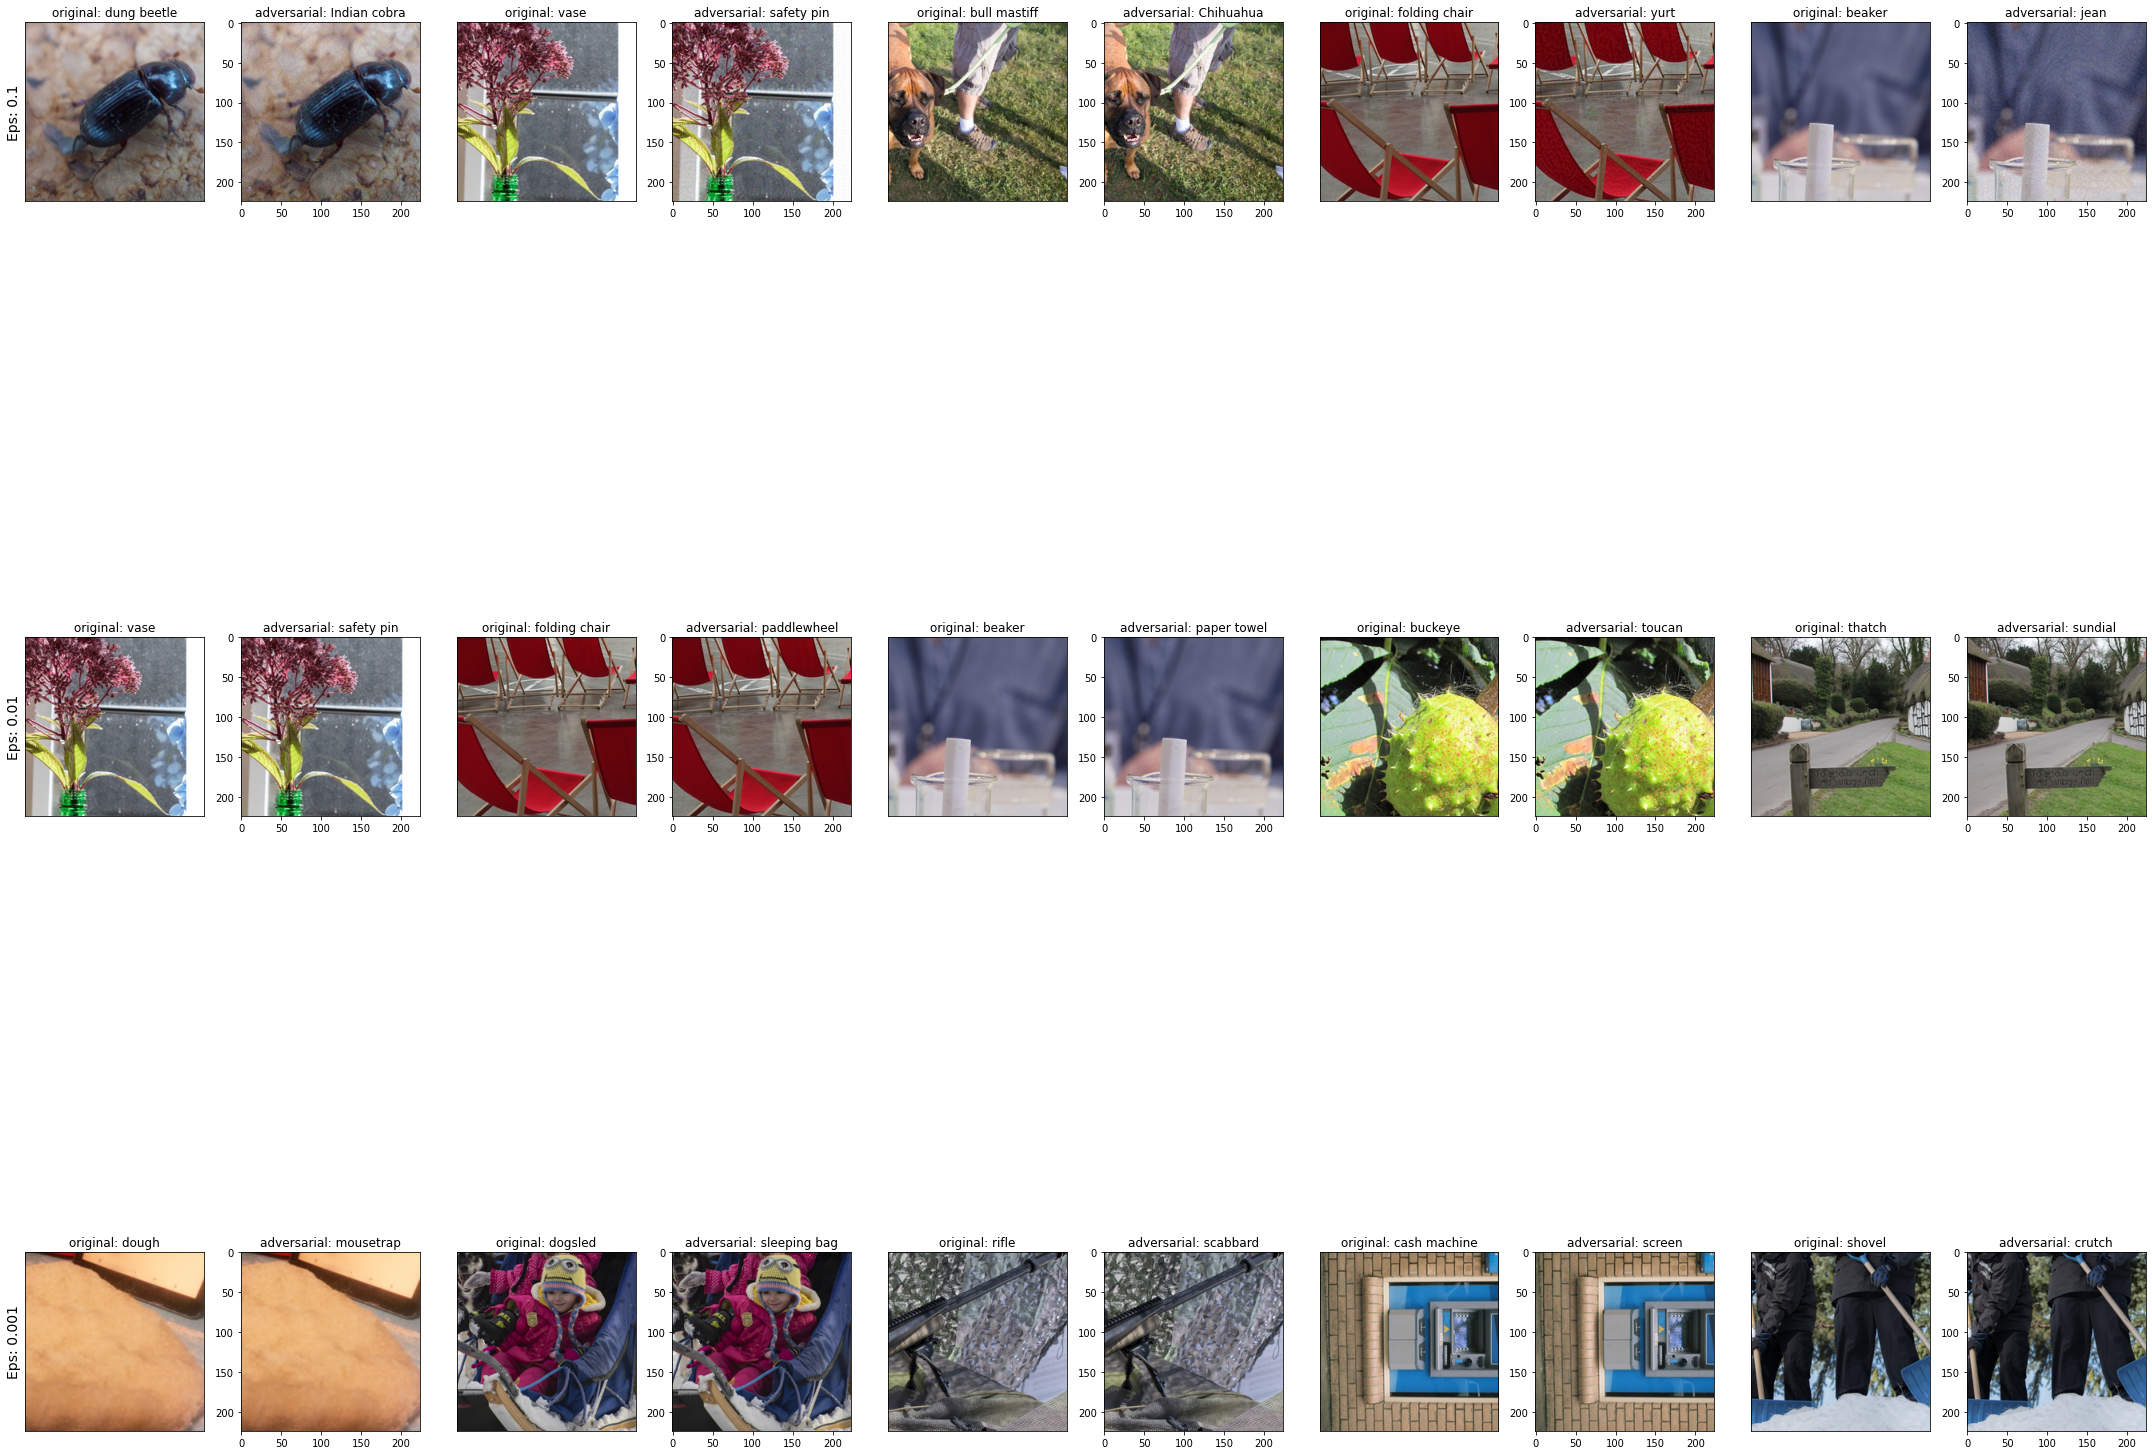

In [9]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
        orig, adv, orig_img, ex = examples[i][j]
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)

plt.tight_layout()
plt.show()